In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from model import LSTMModel, CNN_LSTM
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### **Load the data**

In [3]:
data = pd.read_csv('data/solar_wind_parameters_data_1_hourly_all.csv')

data = data.drop(columns=['Unnamed: 0','Timestamp'])

# data.head()

features = ['Scalar_B', 'BX_GSE_GSM', 'BY_GSE', 'BZ_GSE', 'BY_GSM', 'BZ_GSM', 'Proton_Density', 'SW_Plasma_Temperature', 'SW_Plasma_Speed']
target = ['Dst-index']

# Select the features and target
data = data[features + target]
# data.head()
X = data[features].values
y = data[target].values

print(f'X shape: {X.shape}')
print(f'y shape: {y.shape}')

# Normalize the data
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21, shuffle=False)

# Scale X
scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Scale y (if regression)
scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

# merge X and y
train_data = np.concatenate((X_train_scaled, y_train_scaled), axis=1)
test_data = np.concatenate((X_test_scaled, y_test_scaled), axis=1)

# Split the data into sequences
def sequence(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length, :-1]) # all columns except the last
        y.append(data[i+seq_length, -1])  # target is the last column
        # print(f'X:{np.array(X)}, Y:{np.array(y)}')
    return np.array(X), np.array(y)

SEQ_LENGTH = 24
X_train, y_train = sequence(train_data, SEQ_LENGTH)
X_test, y_test = sequence(test_data, SEQ_LENGTH)

X shape: (212088, 9)
y shape: (212088, 1)


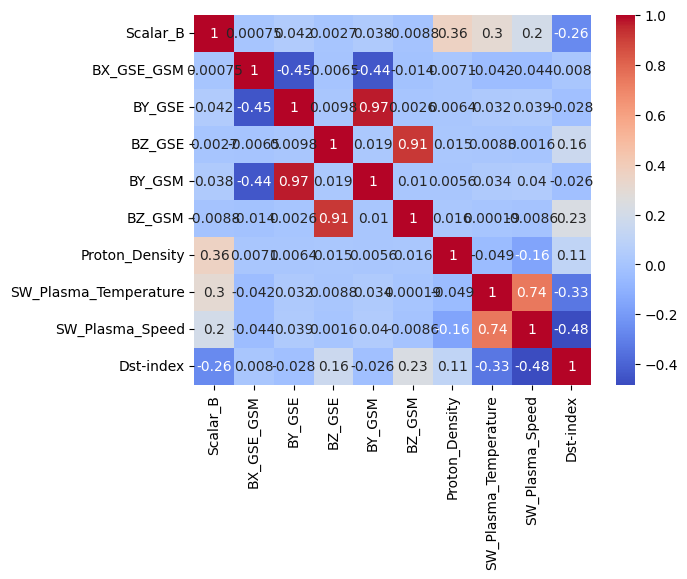

In [4]:
# Plot correlation matrix
import seaborn as sns
corr = data.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

In [5]:
# Convert train & test sequences to sets of tuples (hashable)
train_set = set([tuple(seq.flatten()) for seq in X_train])
test_set = set([tuple(seq.flatten()) for seq in X_test])

leakage = train_set.intersection(test_set)
print(f"Number of overlapping sequences: {len(leakage)}")

Number of overlapping sequences: 0


In [4]:

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

print(f'X_train_tensor shape: {X_train_tensor.shape}')
print(f'y_train_tensor shape: {y_train_tensor.shape}')
print(f'X_test_tensor shape: {X_test_tensor.shape}')
print(f'y_test_tensor shape: {y_test_tensor.shape}')

# Create a DataLoader
train_data = TensorDataset(X_train_tensor, y_train_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 32

train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)

X_train_tensor shape: torch.Size([169646, 24, 9])
y_train_tensor shape: torch.Size([169646])
X_test_tensor shape: torch.Size([42394, 24, 9])
y_test_tensor shape: torch.Size([42394])


### **Load the Model**

In [5]:
# Load the trained model
path = 'results/run4/best_model.pth'
checkpoint = torch.load(f'{path}', map_location=device)
print("Checkpoint keys:", checkpoint.keys())

# Print checkpoint state dict keys
print("\nCheckpoint state dict keys:")
# print(checkpoint['model_state_dict'])
for key in checkpoint['model_state_dict'].keys():
    print(key)

print("\nCheckpoint parameters:")
print(f"input_size: {checkpoint['input_size']}")
print(f"hidden_size: {checkpoint['hidden_size']}")
print(f"num_layers: {checkpoint.get('num_layers', 'Not found')}")

# Recreate the model with explicit parameters
model = LSTMModel(
    input_size=checkpoint['input_size'],
    hidden_size=checkpoint['hidden_size'],
    num_layers=checkpoint.get('num_layers', 2),  # Get from checkpoint or use default
    output_size=1
).to(device)

# Print model's current configuration
print("\nModel configuration:")
print(f"input_size: {model.input_size}")
print(f"hidden_size: {model.hidden_size}")
print(f"num_layers: {model.num_layers}")

# Print current model state dict keys
print("\nCurrent model state dict keys:")
for key in model.state_dict().keys():
    print(key)

try:
    # Load the model weights
    model.load_state_dict(checkpoint['model_state_dict'], strict=True)
    print("\nModel loaded successfully!")
except Exception as e:
    print("\nError loading model:")
    print(e)

Checkpoint keys: dict_keys(['epoch', 'model_state_dict', 'optimizer_state_dict', 'loss', 'input_size', 'hidden_size', 'num_layers'])

Checkpoint state dict keys:
lstm.weight_ih_l0
lstm.weight_hh_l0
lstm.bias_ih_l0
lstm.bias_hh_l0
lstm.weight_ih_l1
lstm.weight_hh_l1
lstm.bias_ih_l1
lstm.bias_hh_l1
fc.weight
fc.bias

Checkpoint parameters:
input_size: 9
hidden_size: 48
num_layers: 2

Model configuration:
input_size: 9
hidden_size: 48
num_layers: 2

Current model state dict keys:
lstm.weight_ih_l0
lstm.weight_hh_l0
lstm.bias_ih_l0
lstm.bias_hh_l0
lstm.weight_ih_l1
lstm.weight_hh_l1
lstm.bias_ih_l1
lstm.bias_hh_l1
fc.weight
fc.bias

Model loaded successfully!


### **Plot**

In [6]:
# Predict
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)
    # print(f'y_pred:{y_pred.shape} {y_pred}')

# Convert true values to NumPy
y_test = y_test_tensor.cpu().numpy()

# Fix the shape by flattening y_pred
y_pred = y_pred.cpu().numpy().flatten()
# print(f'y_pred:{y_pred.shape} {y_pred}')

# Inverse transform the scaled values
y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_original = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()

print(f'y_pred_original:{y_pred_original.shape} {y_pred_original}')

from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test_original, y_pred_original)
print(f'MSE: {mse:.2f}')

y_pred_original:(42394,) [-19.922037 -21.207045 -21.176304 ...  -9.803851  -9.803274  -9.782167]
MSE: 86.20


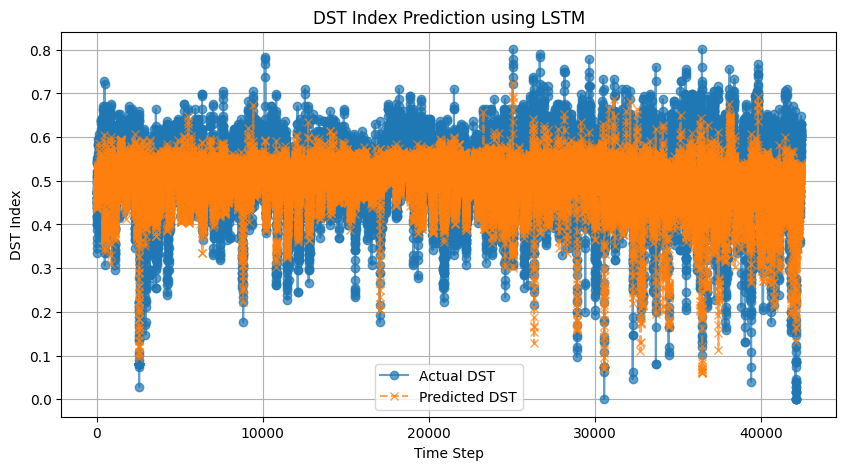

In [7]:
plt.figure(figsize=(10,5))
plt.plot(y_test, label="Actual DST", linestyle='-', marker='o', alpha=0.7)
plt.plot(y_pred, label="Predicted DST", linestyle='--', marker='x', alpha=0.7)

plt.xlabel("Time Step")
plt.ylabel("DST Index")
plt.title("DST Index Prediction using LSTM")
plt.legend()
plt.grid()
plt.show()